## Evaluation of showers submitted to the Fast Calorimeter Challenge 2022

This is an interactive version of the file ```evaluate.py```. It can also be run directly using:

```
python evaluate.py -i INPUT_FILE -r REFERENCE_FILE -m MODE -d DATASET --output_dir OUTPUT_DIR --source_dir SOURCE_DIR
```

where the arguments are:

- ```INPUT_FILE``` is the .hdf5 file that contains the showers to be evaluated.

- ```REFERENCE_FILE``` is either the .hdf5 file that contains the showers the input is compared to, or the .pkl file that is created when the code is run for the first time. The latter contains all relevant high-level features and using it results in a faster runtime.

- ```MODE``` is one of [all, avg, avg-E, hist, hist-p, hist-chi], and defaults to 'all'. 'avg' plots the average shower of all provided events; 'avg-E' plots the average shower in smaller energy ranges; 'hist' plots histograms of high-level features and saves the separation power, a measure of difference between the histogram of the provided file and the histogram of a reference in SOURCE_DIR, into a file; 'hist-p' only plots the histograms; 'hist-chi' only saves the separation power; and 'all' does all of the above.

- ```DATASET``` is the name of the dataset that should be evaluated. Must be one of [1-photons, 1-pions, 2, 3].

- ```OUTPUT_DIR``` is the folder in which the plots and other files will be stored. It defaults to 'evaluation_results/'.

- ```SOURCE_DIR``` is the folder in which the reference .pkl will be stored. In the future, it will also be where the .hdf5 files for the classifier are saved


In [1]:
import os
import evaluate
import argparse
import h5py
import numpy as np

import HighLevelFeatures as HLF

In [2]:
# specify to your needs:

INPUT_FILE = '../dataset_2_1.hdf5'
REFERENCE_FILE = '../dataset_2_2.hdf5' 
#REFERENCE_FILE = 'source/dataset_2_2.pkl'
MODE = 'all' # not really needed here because the nb is interactive
DATASET = '2'
OUTPUT_DIR = 'evaluation_results/'
SOURCE_DIR = 'source/'

In [3]:
# emulating the argument parser of evaluate.py
parser_replacement = {
    'input_file': INPUT_FILE, 'reference_file': REFERENCE_FILE, 'mode': MODE, 'dataset': DATASET, 
    'output_dir': OUTPUT_DIR, 'source_dir': SOURCE_DIR, }
args = argparse.Namespace(**parser_replacement)

In [5]:
# reading in source file
source_file = h5py.File(args.input_file, 'r')

# checking if it has correct shape
evaluate.check_file(source_file, args)

# preparing output directory
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

# extracting showers and energies from source file
shower, energy = evaluate.extract_shower_and_energy(source_file, args, which='input')

# creating helper class for high-level features
particle = {'1-photons': 'photon', '1-pions': 'pion',
            '2': 'electron', '3': 'electron'}[args.dataset]
hlf = HLF.HighLevelFeatures(particle, filename='binning_dataset_{}.xml'.format(args.dataset.replace('-', '_')))



Checking if provided file has the correct form ...
Found 100000 events in the file.
Checking if provided file has the correct form: DONE 

Extracting showers from input file ...
Extracting showers from input file: DONE.



In [6]:
# reading in reference
if os.path.splitext(args.reference_file)[1] == '.hdf5':
    print("using .hdf5 reference")
    reference_file = h5py.File(args.reference_file, 'r')
    evaluate.check_file(reference_file, args, which='reference')
    reference_hlf = HLF.HighLevelFeatures(particle, filename='binning_dataset_{}.xml'.format(
        args.dataset.replace('-', '_')))
    reference_shower, reference_energy = evaluate.extract_shower_and_energy(reference_file, args, which='reference')
    reference_hlf.Einc = reference_energy
    evaluate.save_reference(reference_hlf, args.reference_file, args)

elif os.path.splitext(args.reference_file)[1] == '.pkl':
    print("using .pkl file for reference")
    reference_hlf = evaluate.load_reference(args.reference_file)
else:
    raise ValueError("reference_file must be .hdf5 or .pkl!")


using .hdf5 reference
Checking if reference file has the correct form ...
Found 100000 events in the file.
Checking if reference file has the correct form: DONE 

Extracting showers from reference file ...
Extracting showers from reference file: DONE.

Saving file with high-level features.
Saving file with high-level features DONE.


Plotting average shower...
Saving file with high-level features.
Saving file with high-level features DONE.
Plotting average shower: DONE.



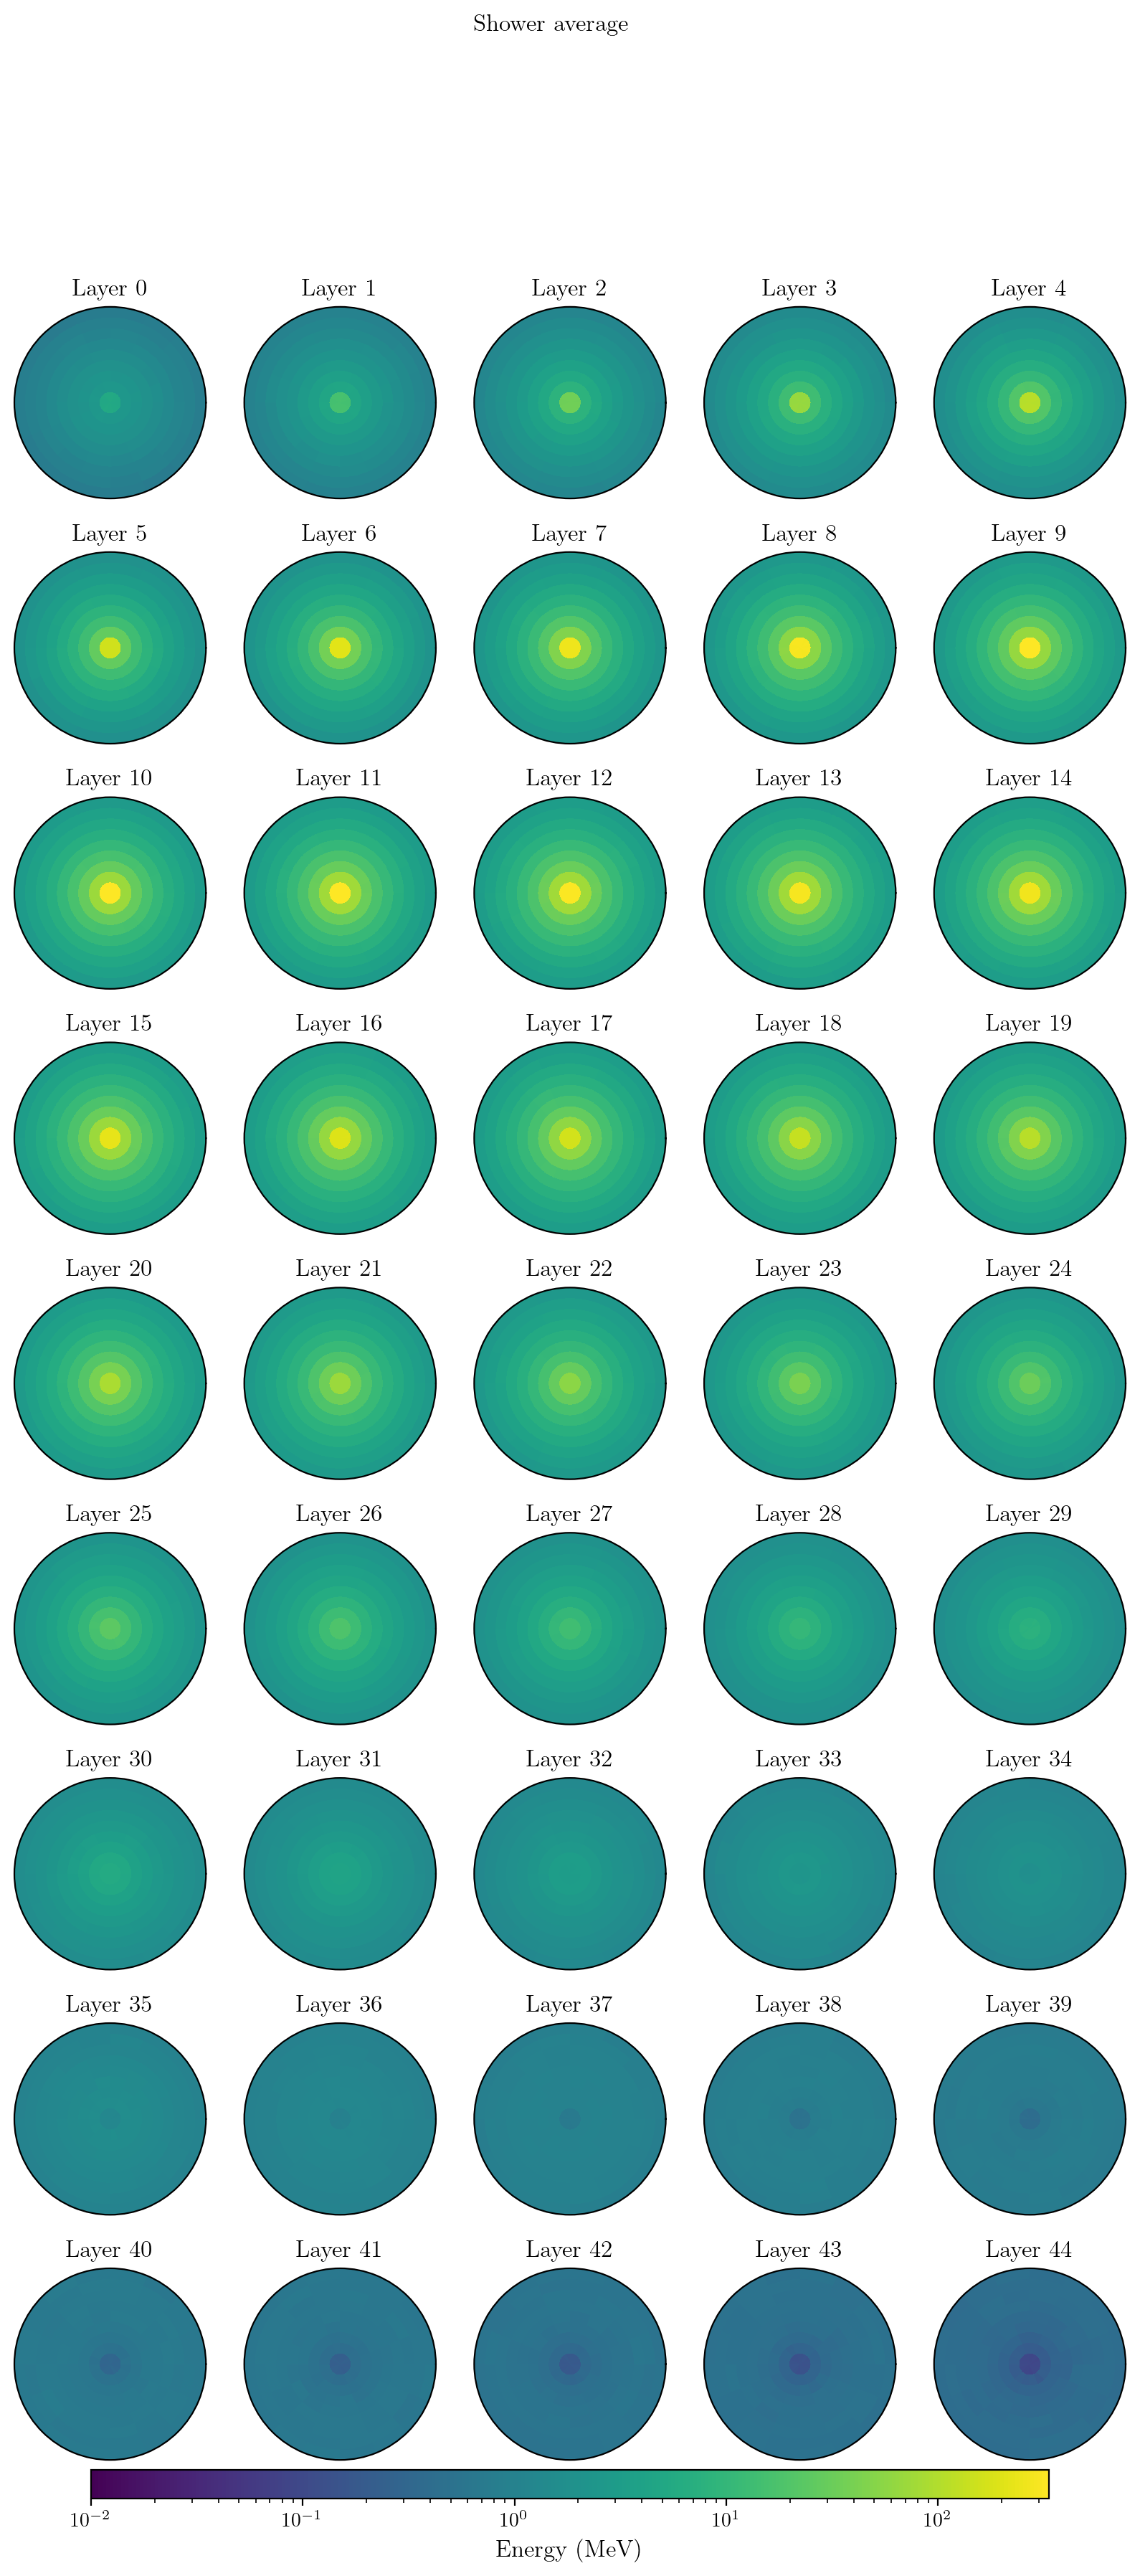

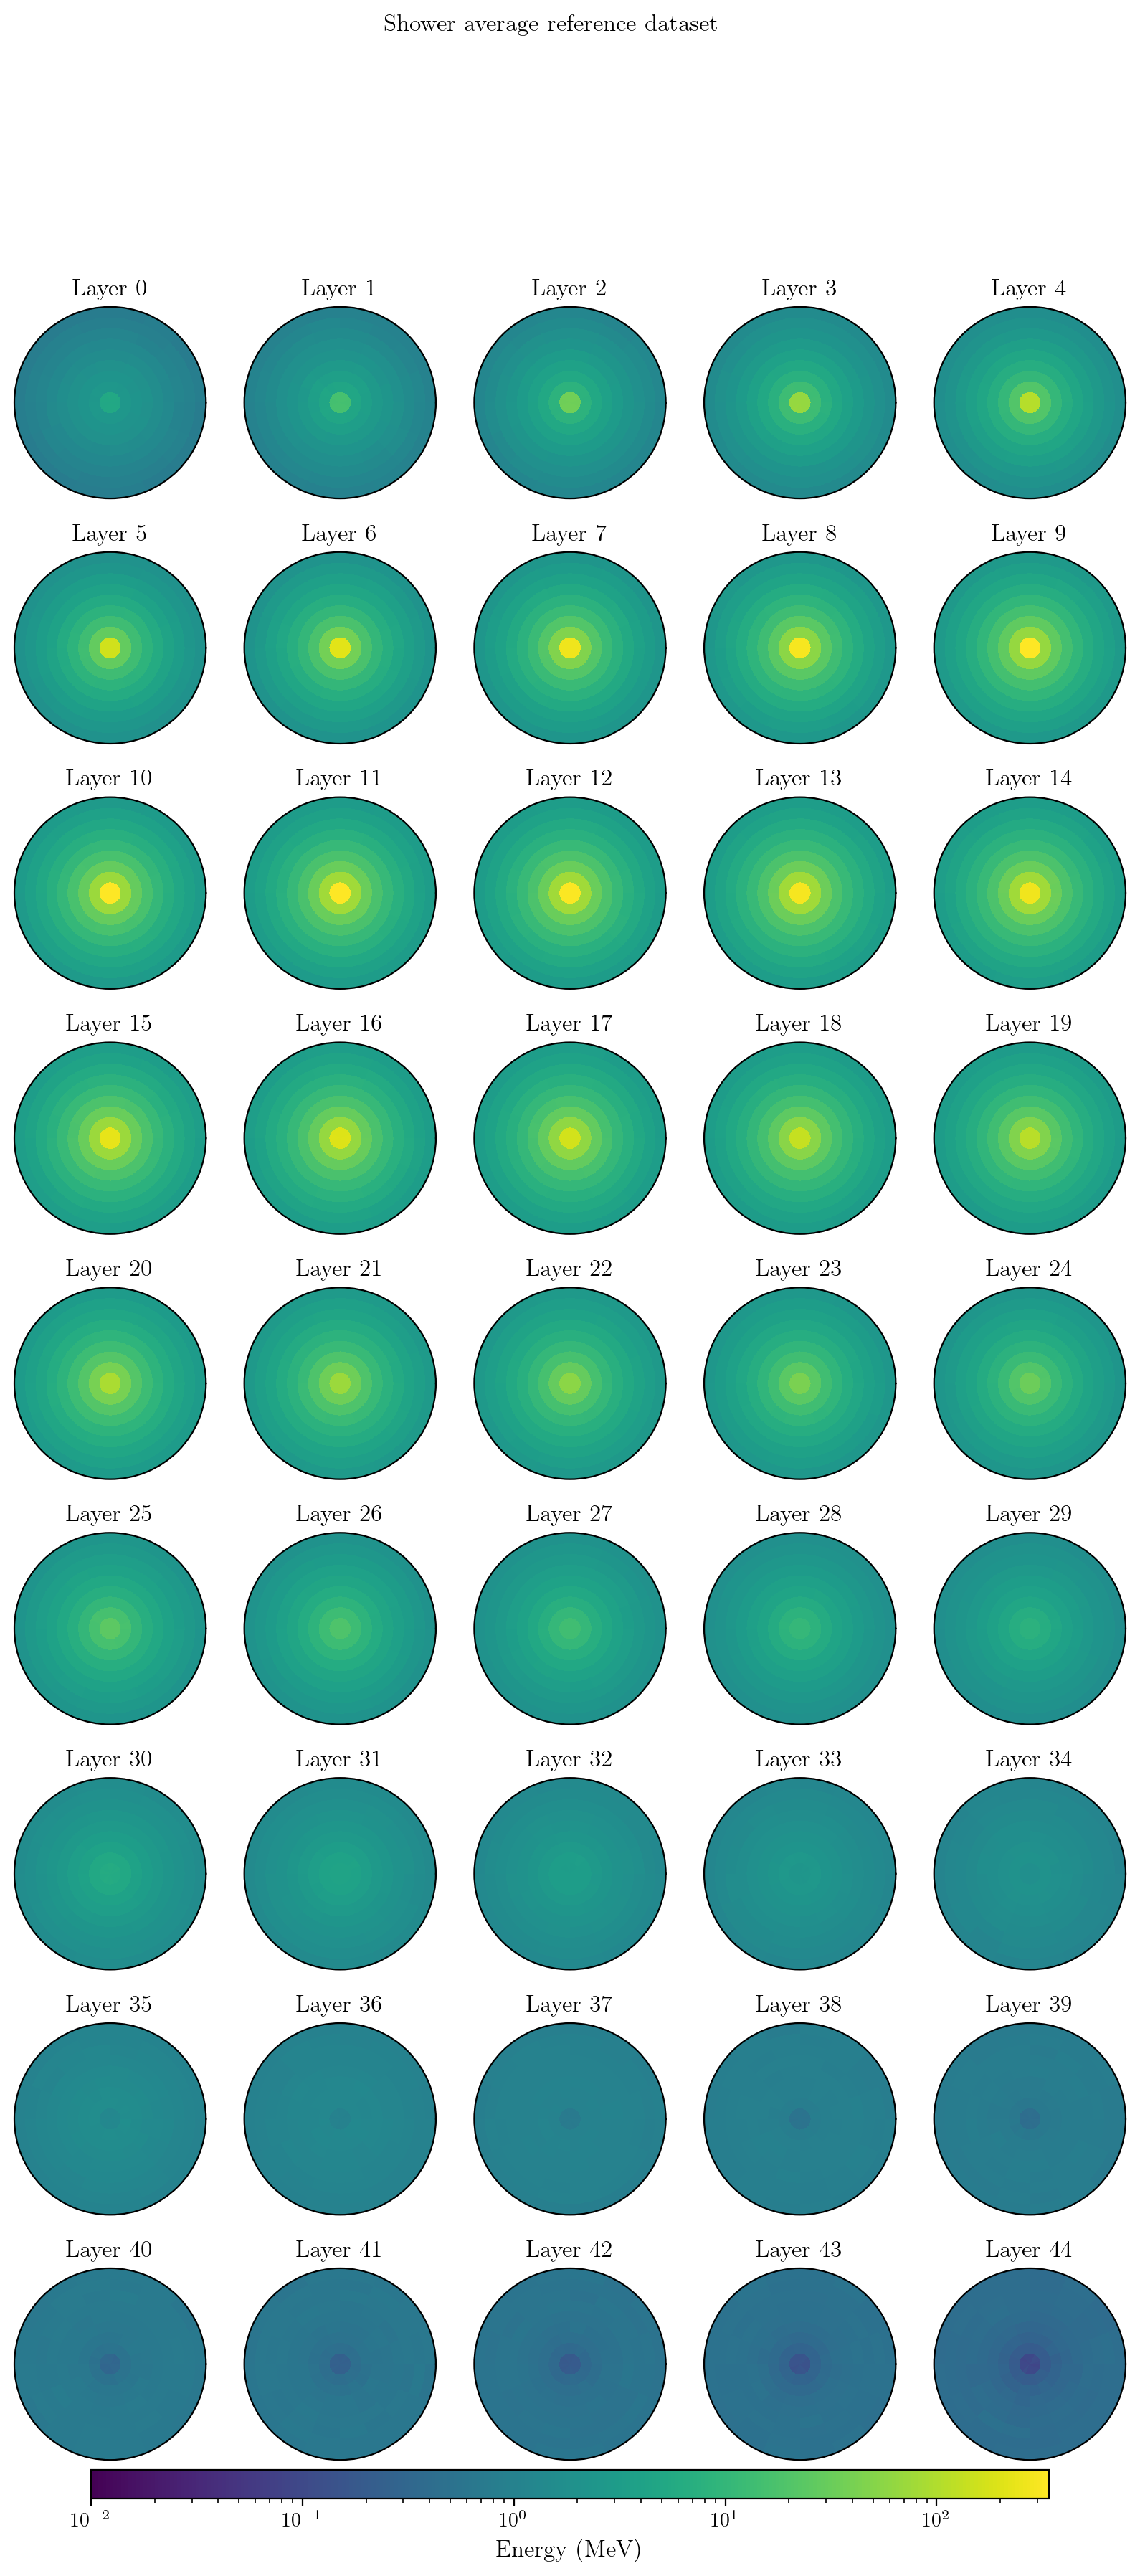

In [7]:
# evaluation mode 'avg': average of given showers
print("Plotting average shower...")
_ = hlf.DrawAverageShower(shower, filename=os.path.join(args.output_dir, 
                                                        'average_shower_dataset_{}.png'.format(args.dataset)),
                                  title="Shower average")
if hasattr(reference_hlf, 'avg_shower'):
    pass
else:
    reference_hlf.avg_shower = reference_shower.mean(axis=0, keepdims=True)
    evaluate.save_reference(reference_hlf, args.reference_file, args)
_ = hlf.DrawAverageShower(reference_hlf.avg_shower, 
                          filename=os.path.join(args.output_dir, 'reference_average_shower_dataset_{}.png'.format(
                                          args.dataset)),
                          title="Shower average reference dataset")
print("Plotting average shower: DONE.\n")


Plotting average showers for different energies ...
Saving file with high-level features.
Saving file with high-level features DONE.
Saving file with high-level features.
Saving file with high-level features DONE.
Saving file with high-level features.
Saving file with high-level features DONE.
Plotting average shower for different energies: DONE.



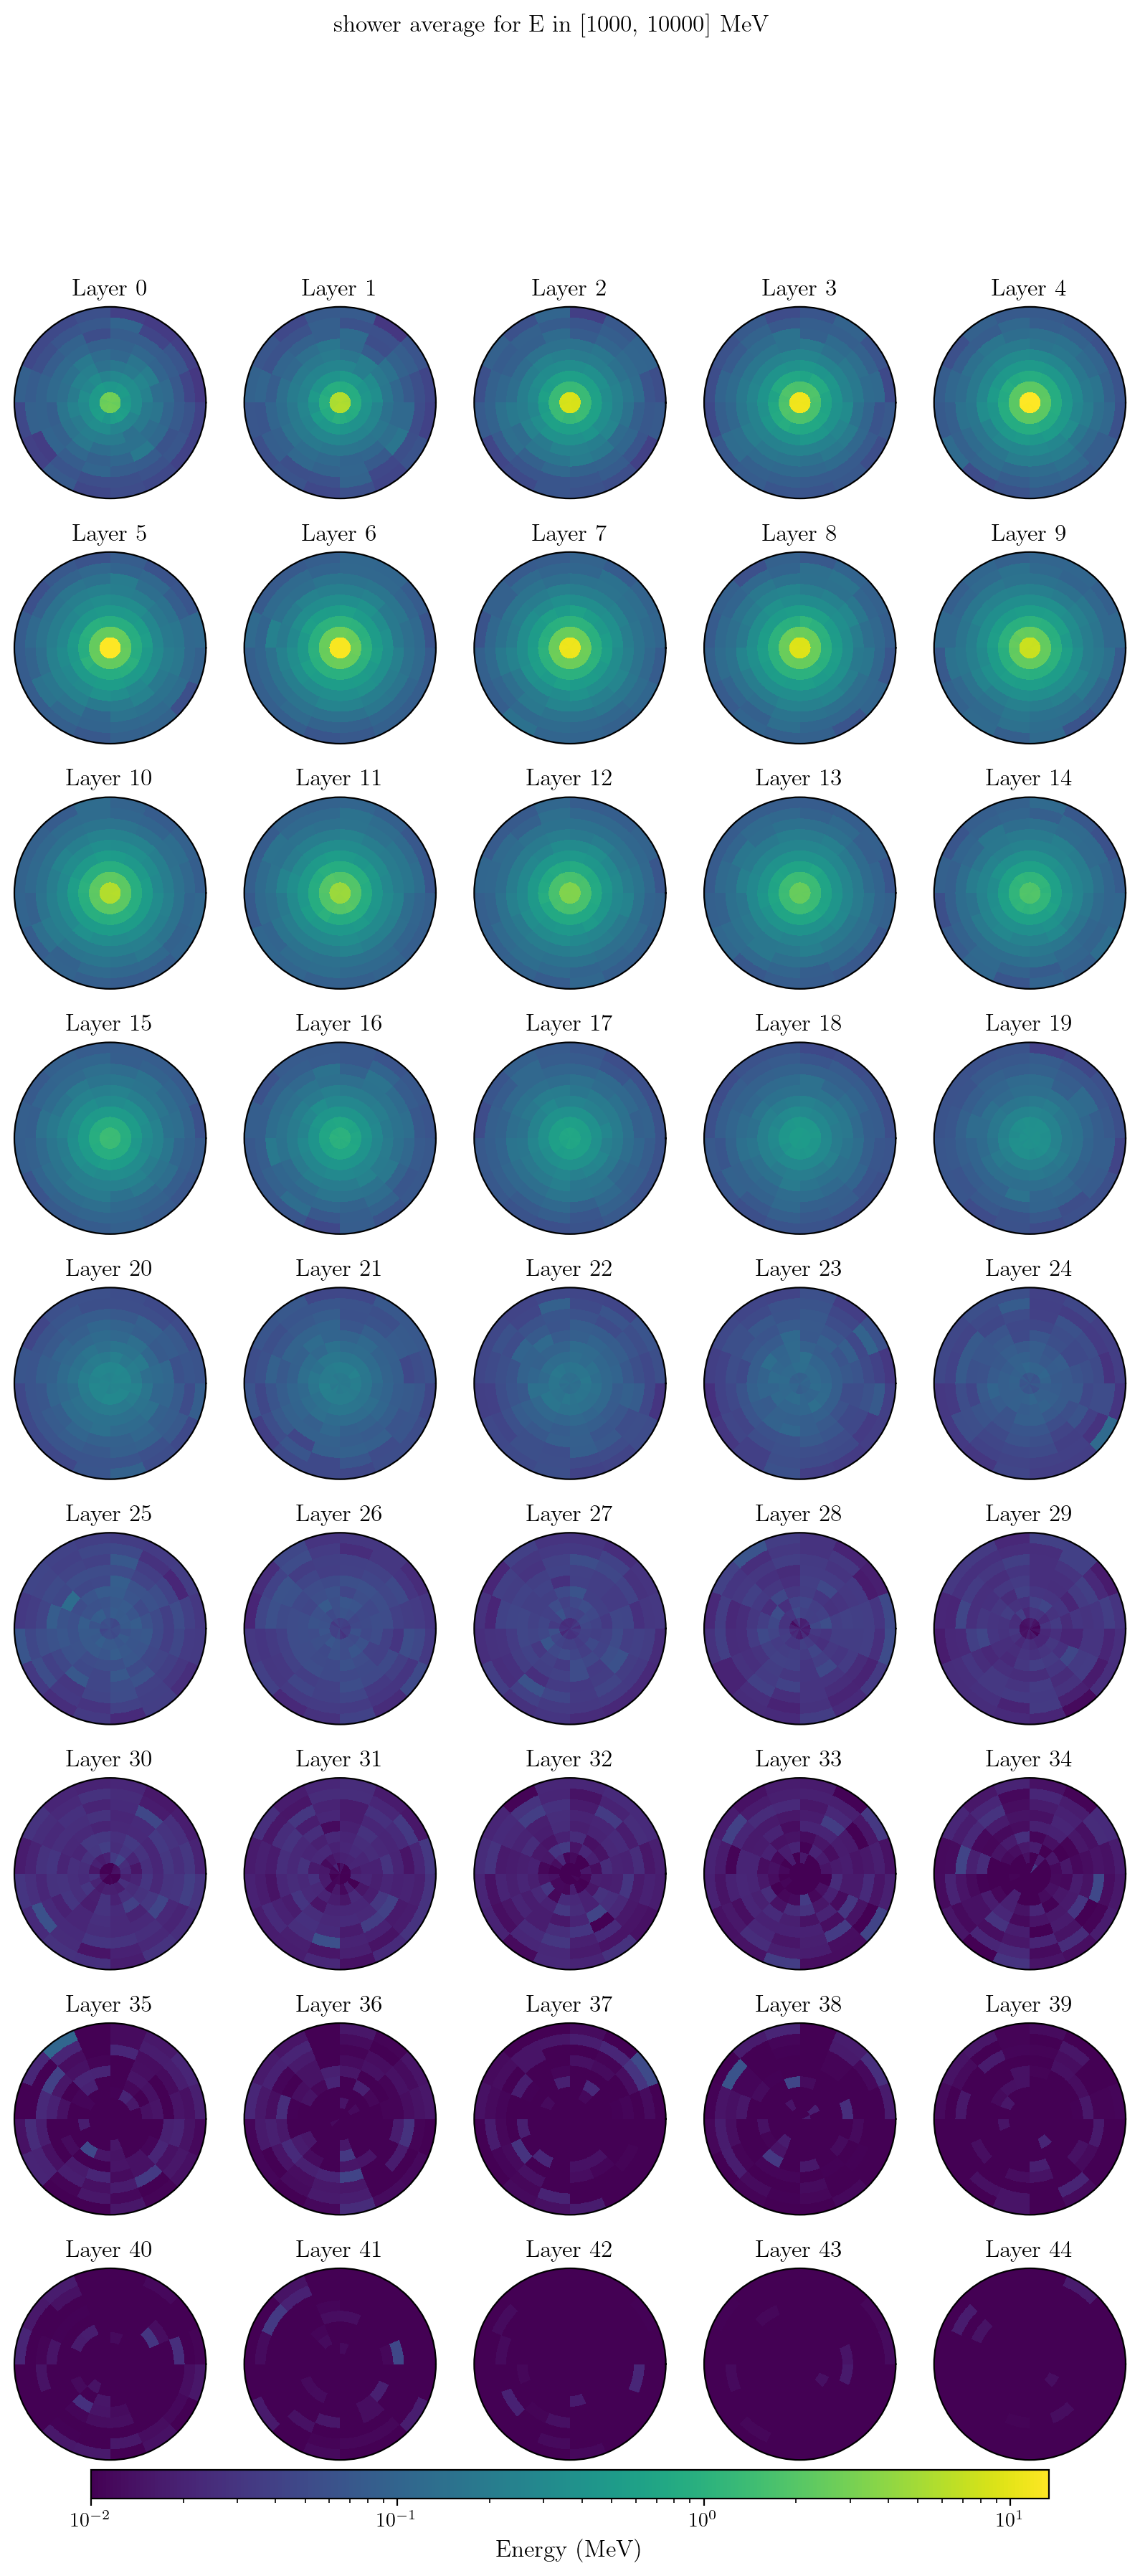

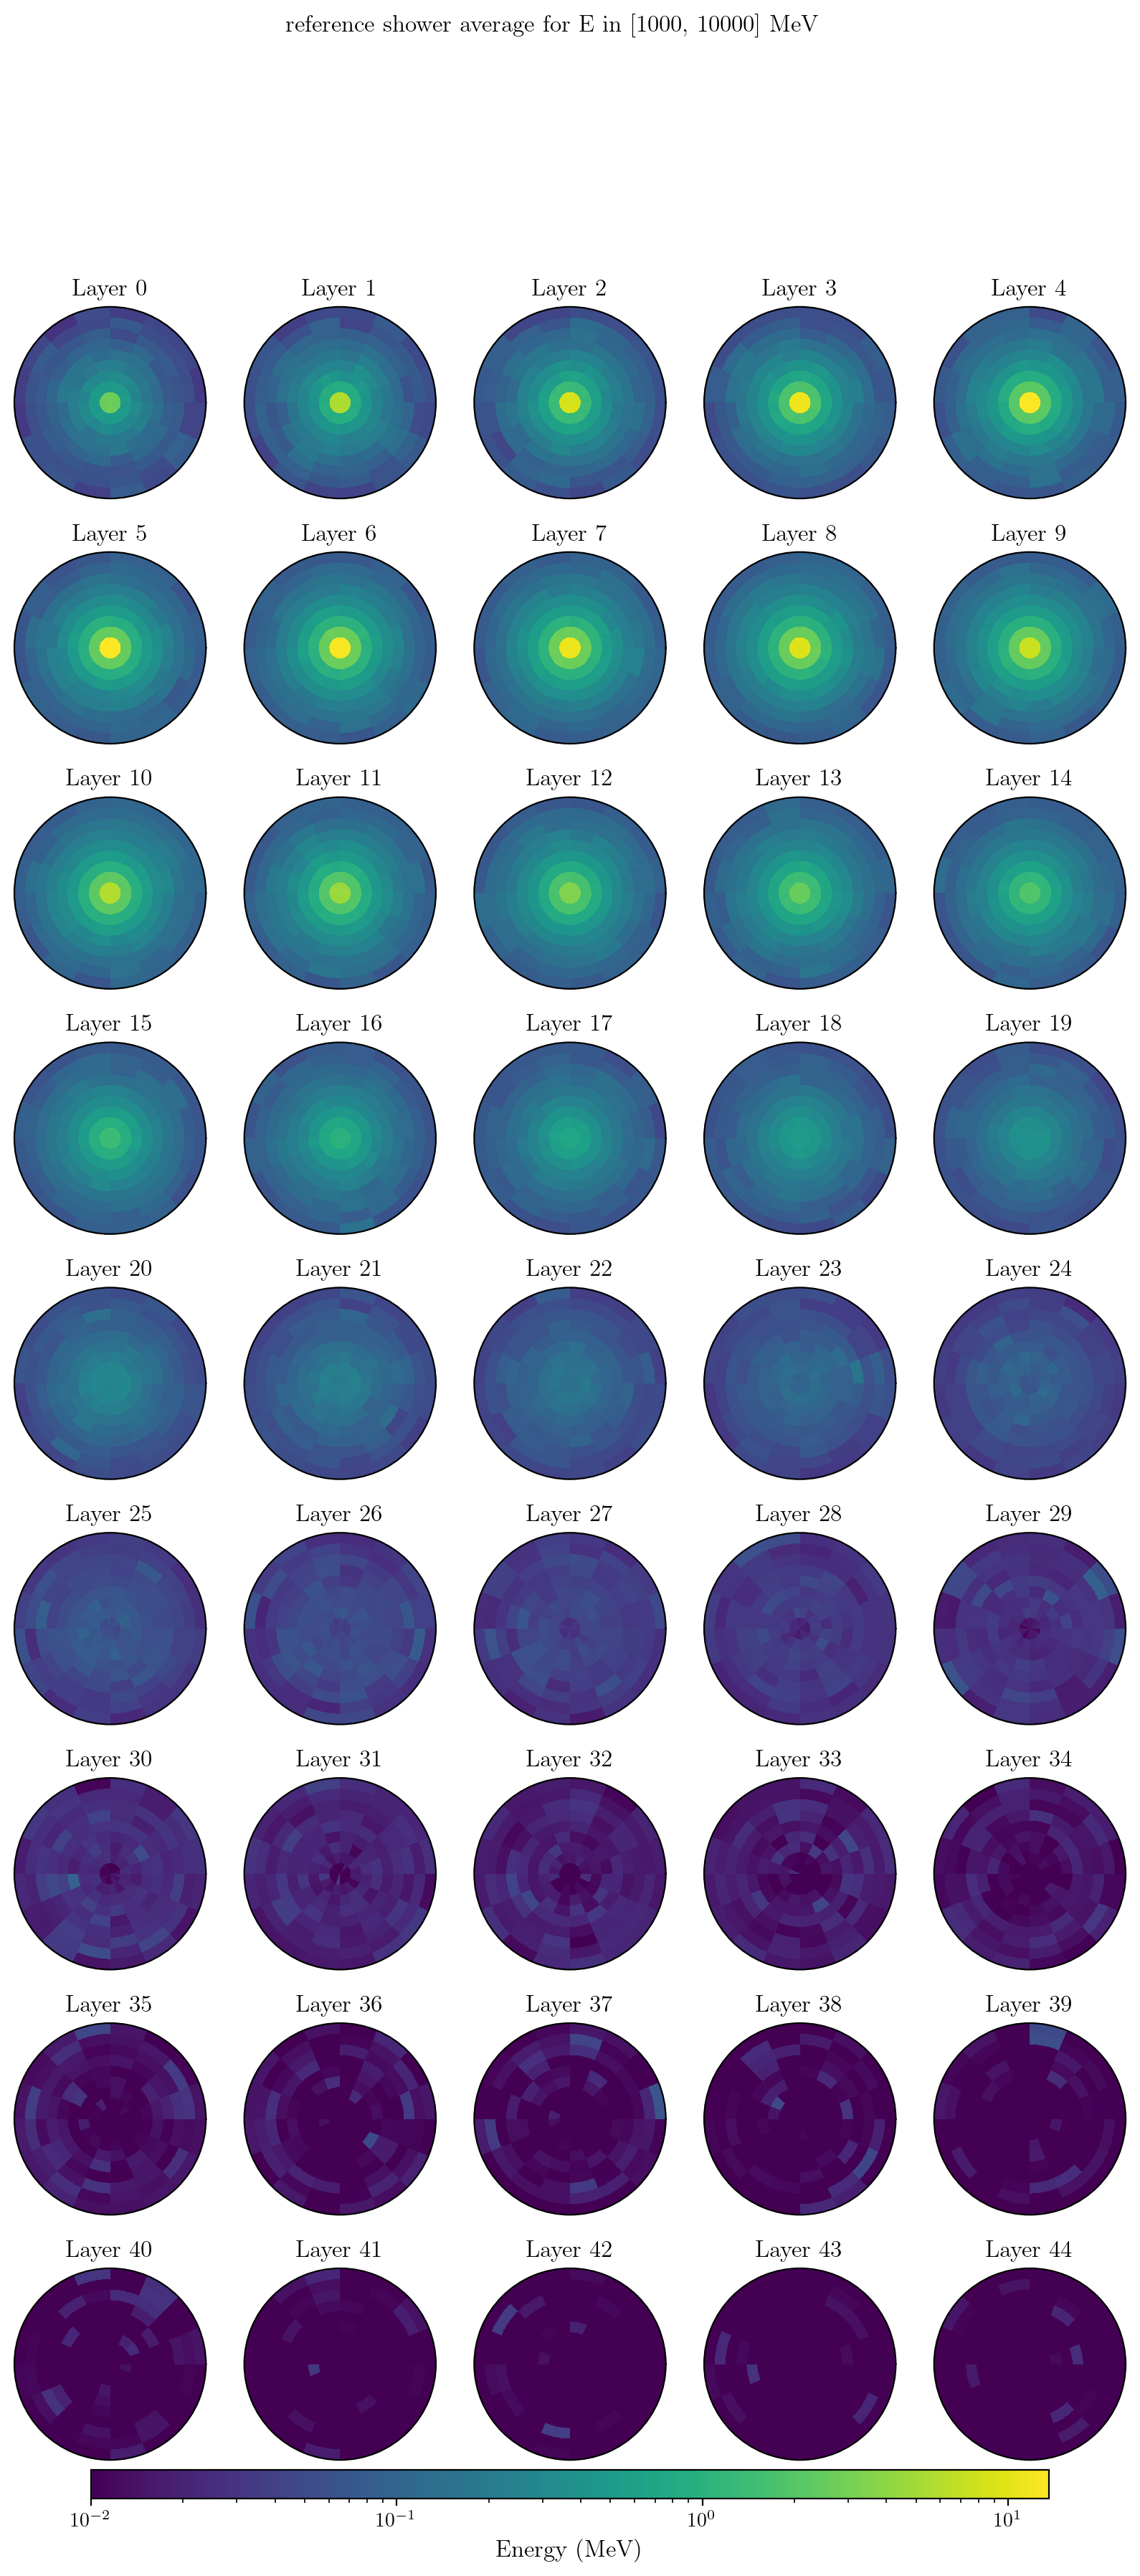

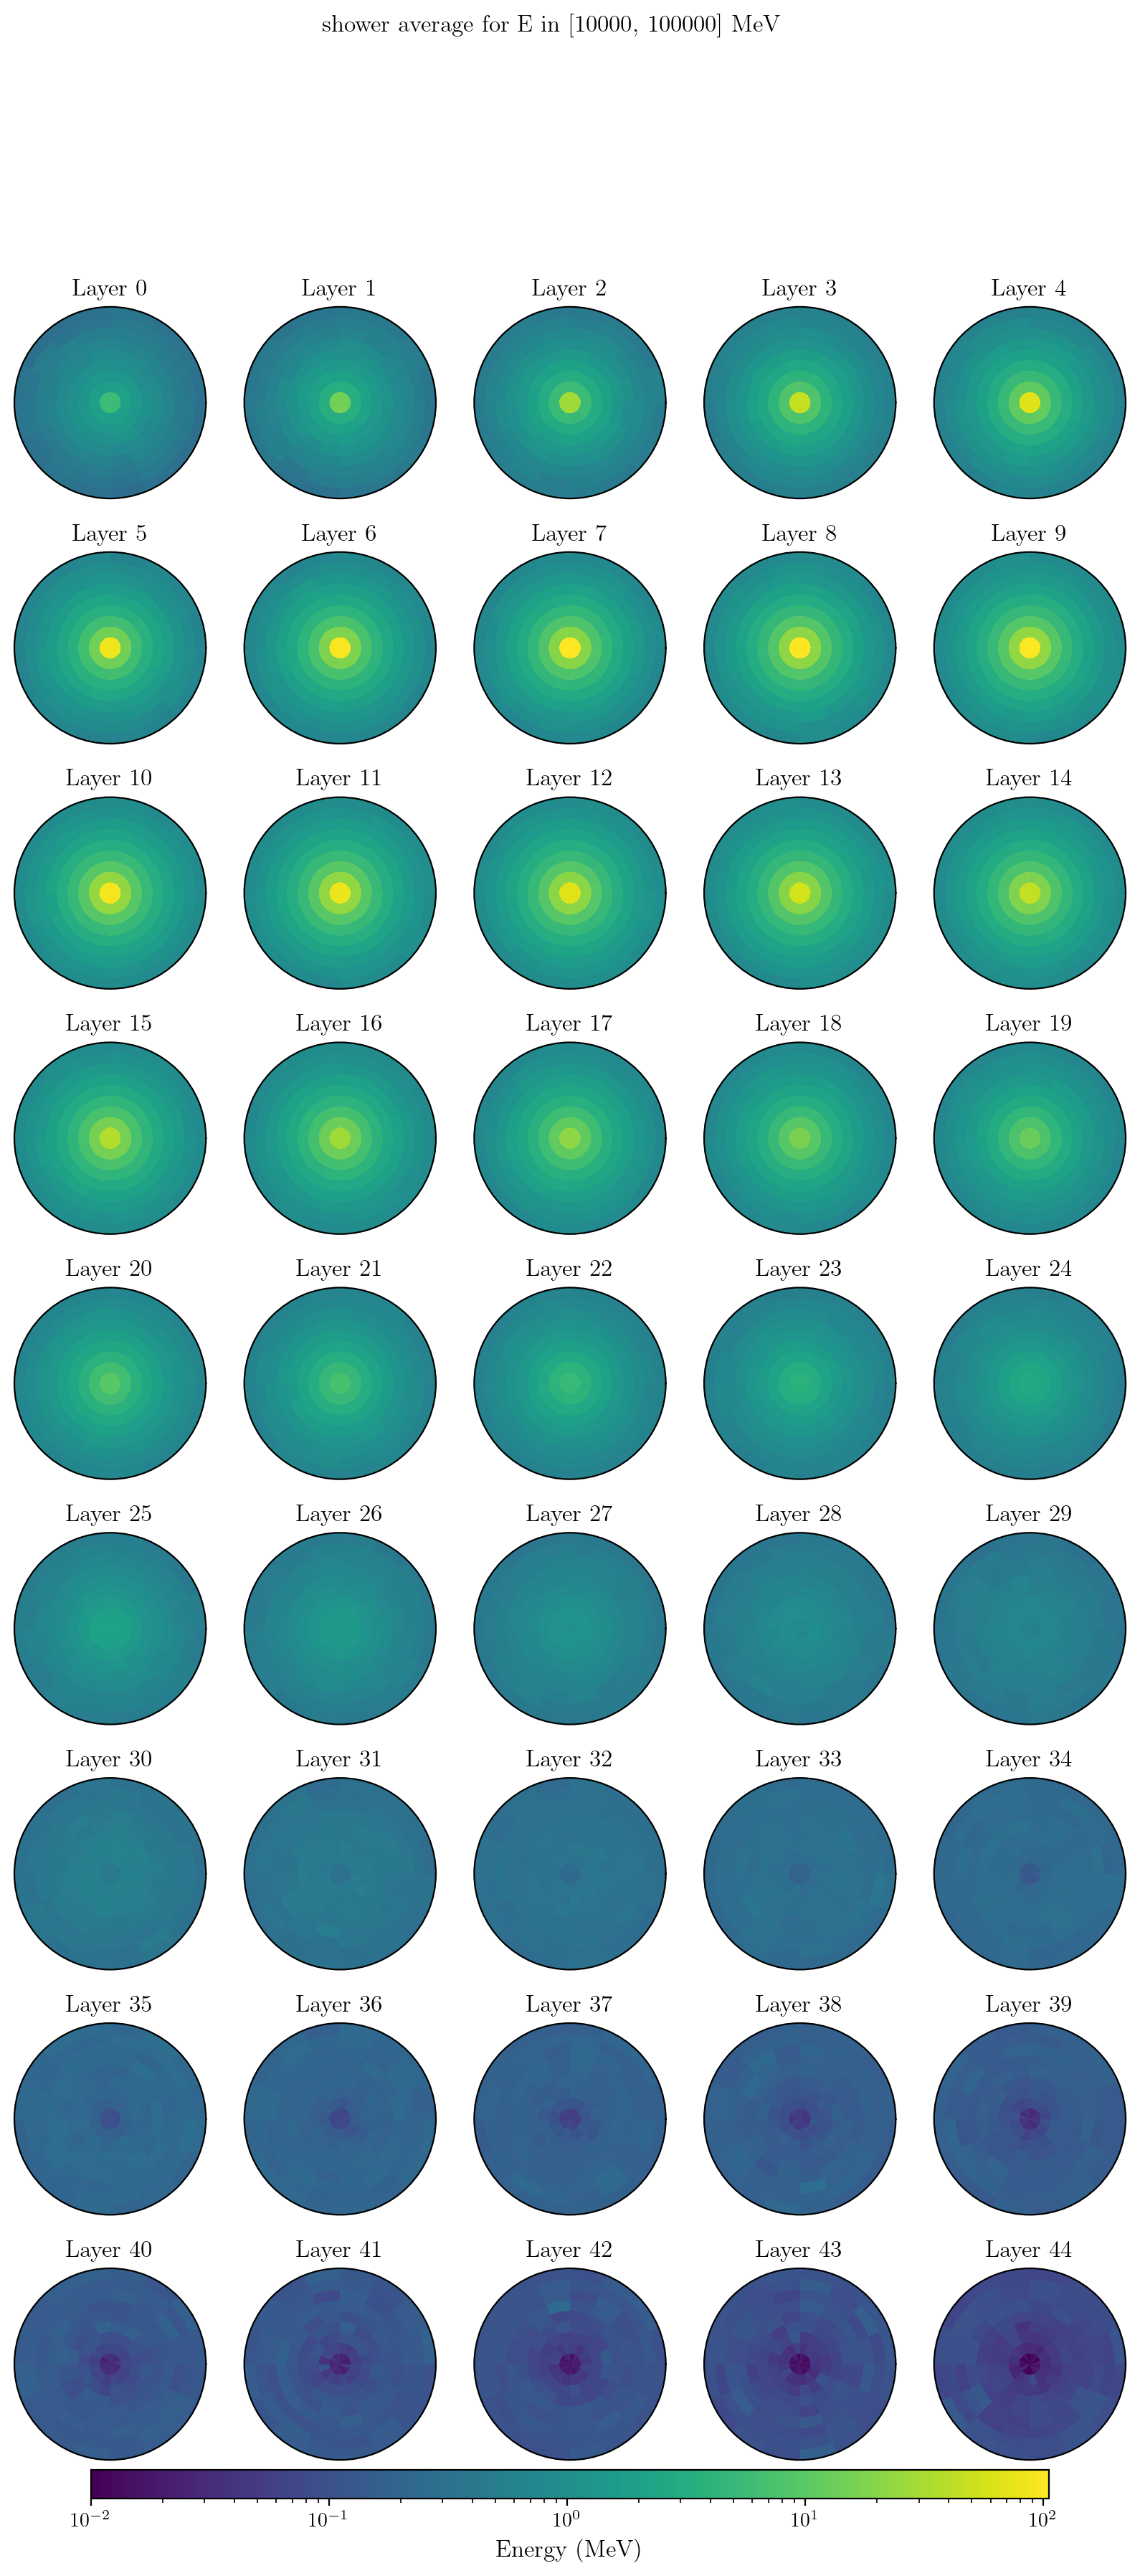

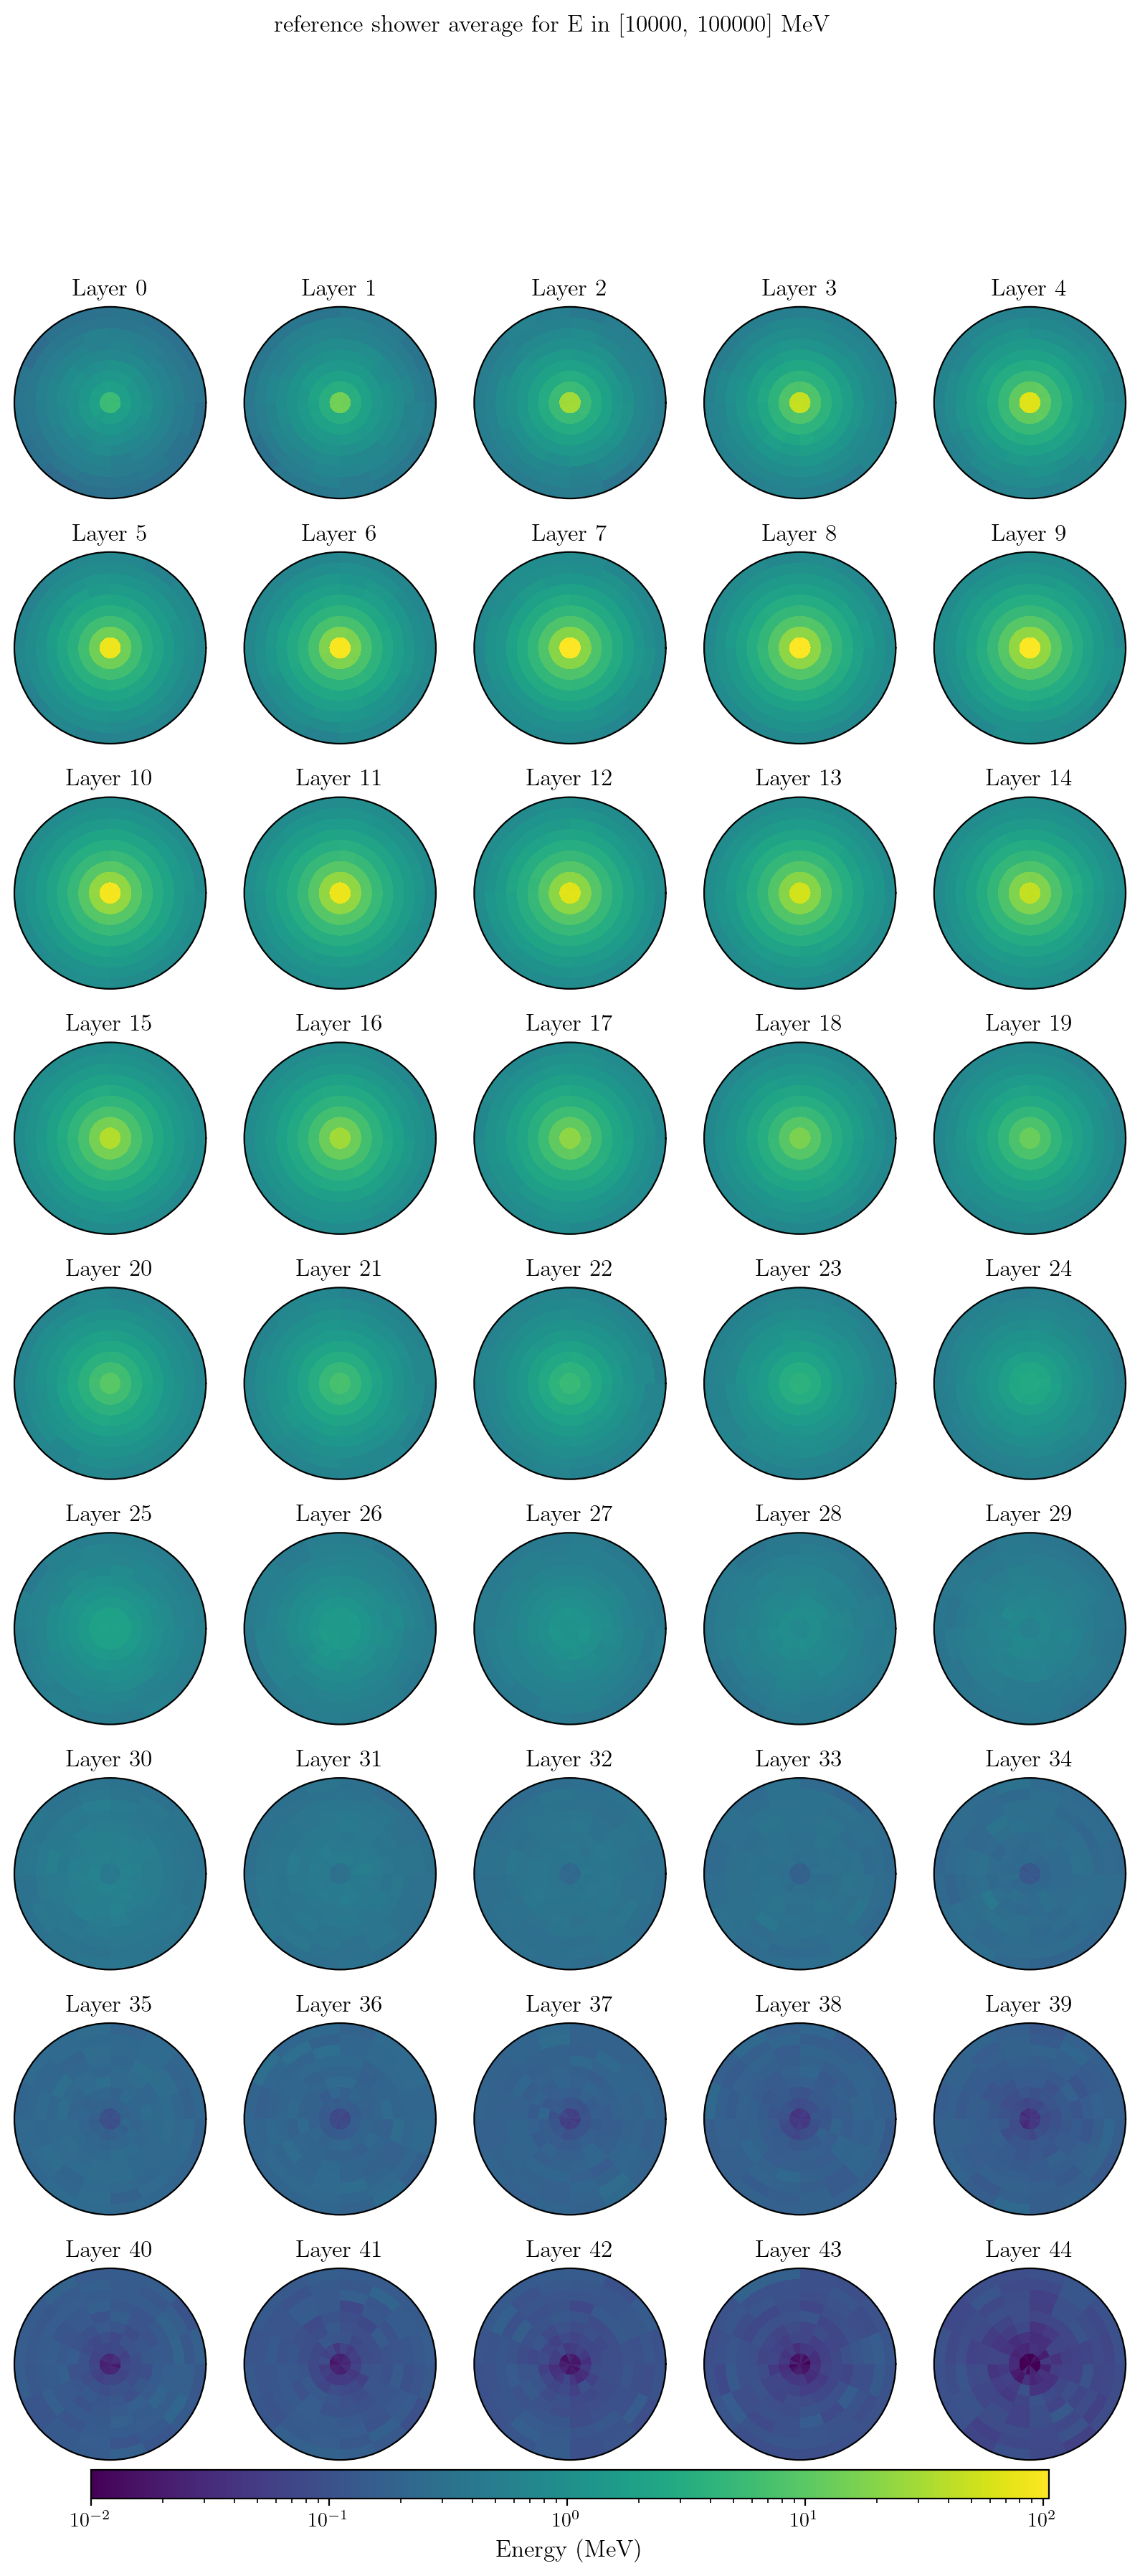

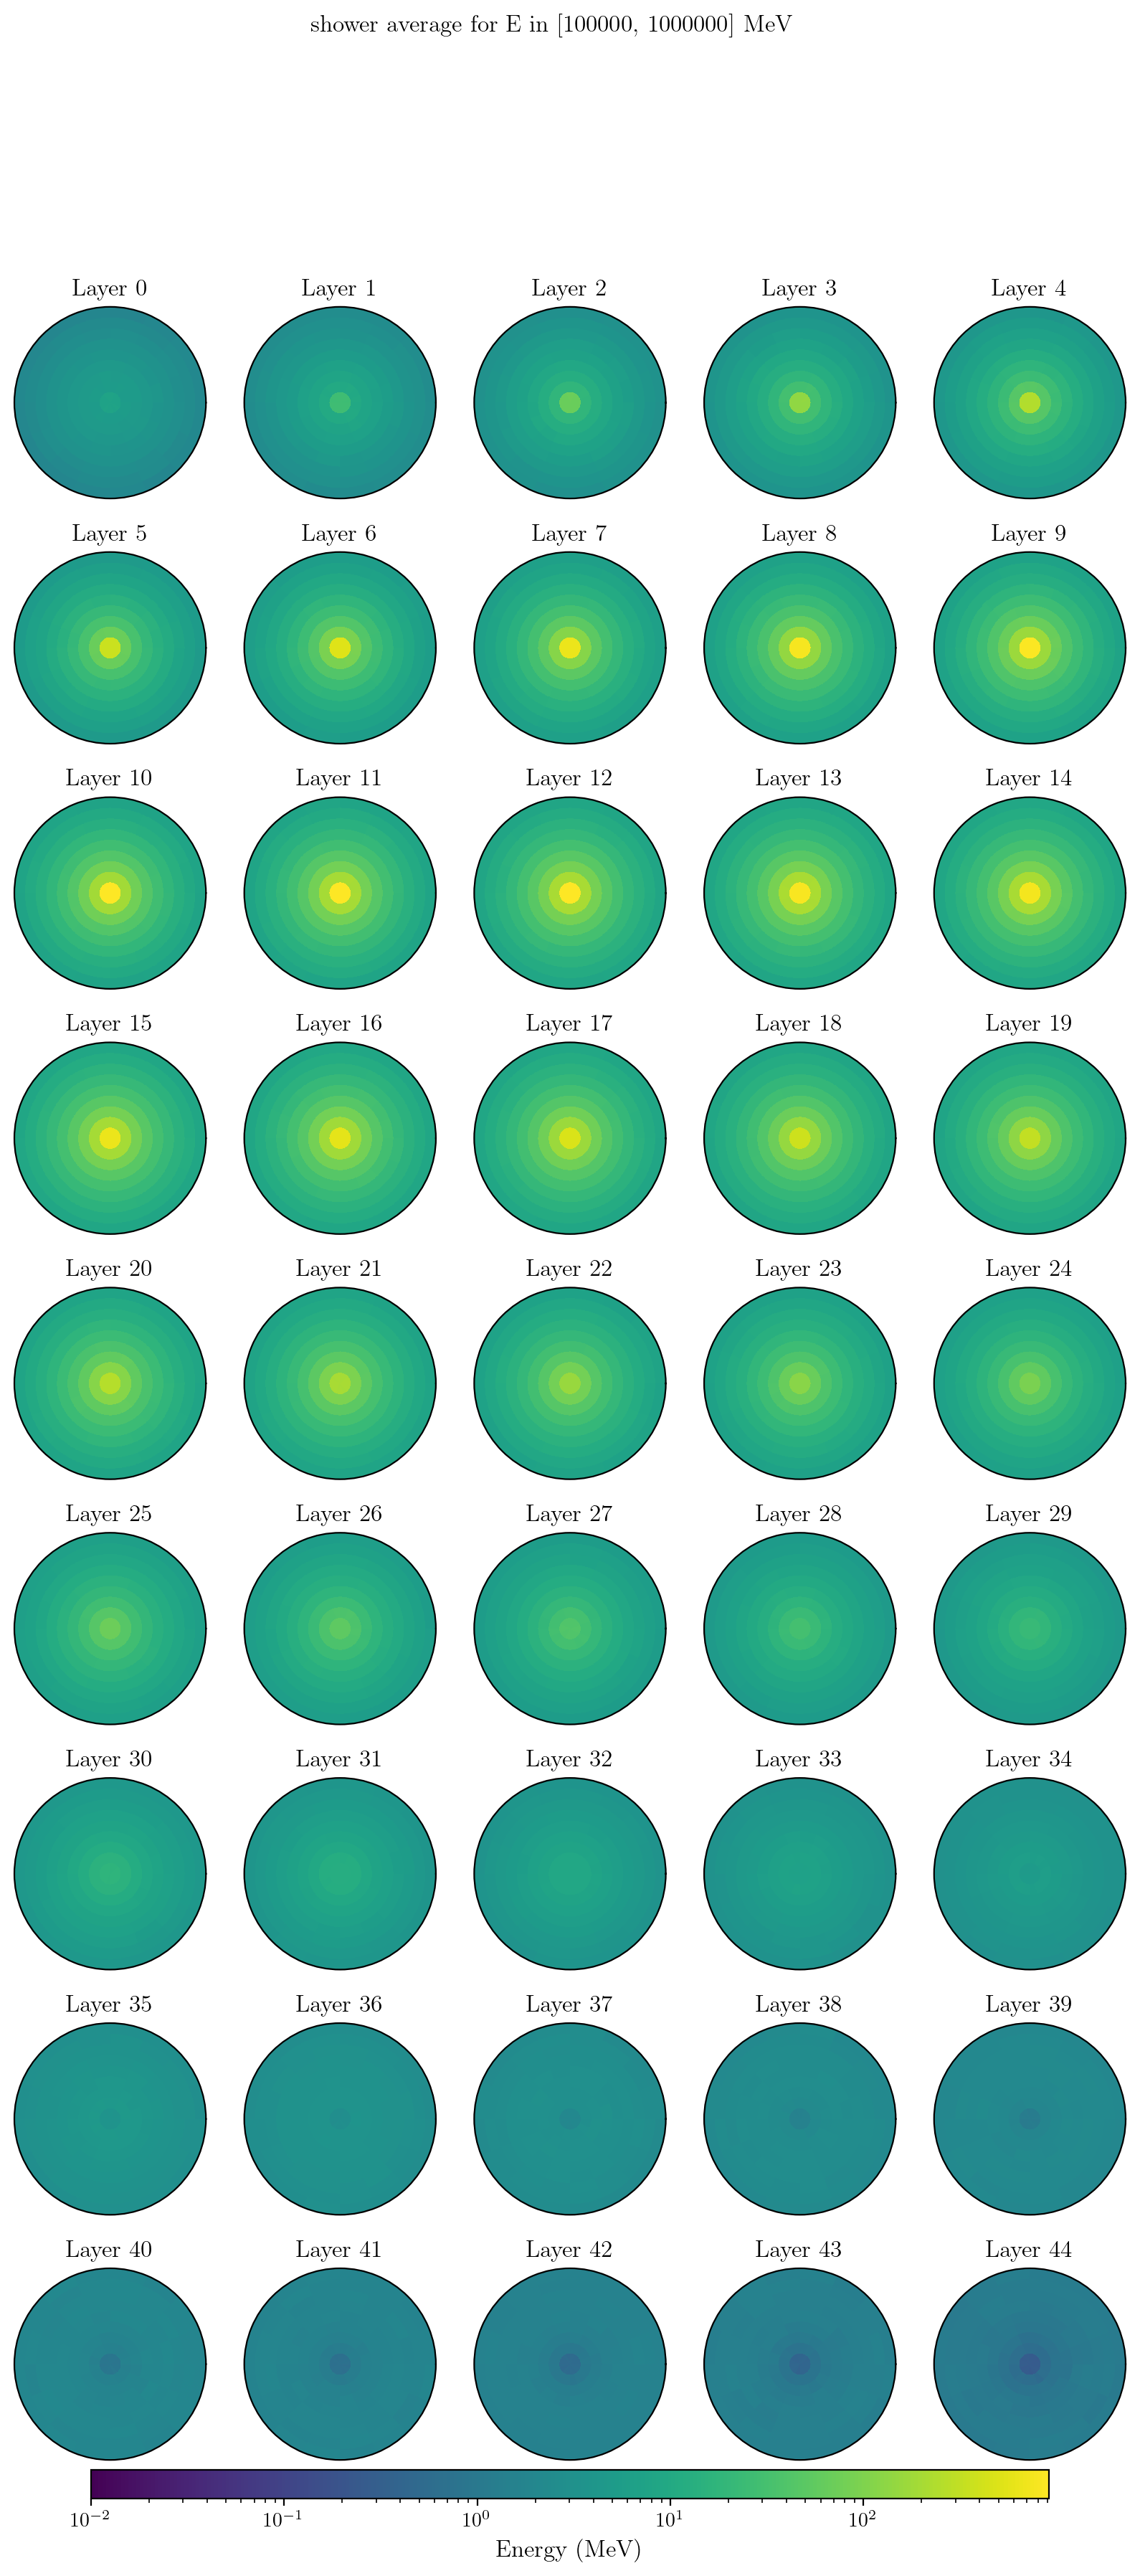

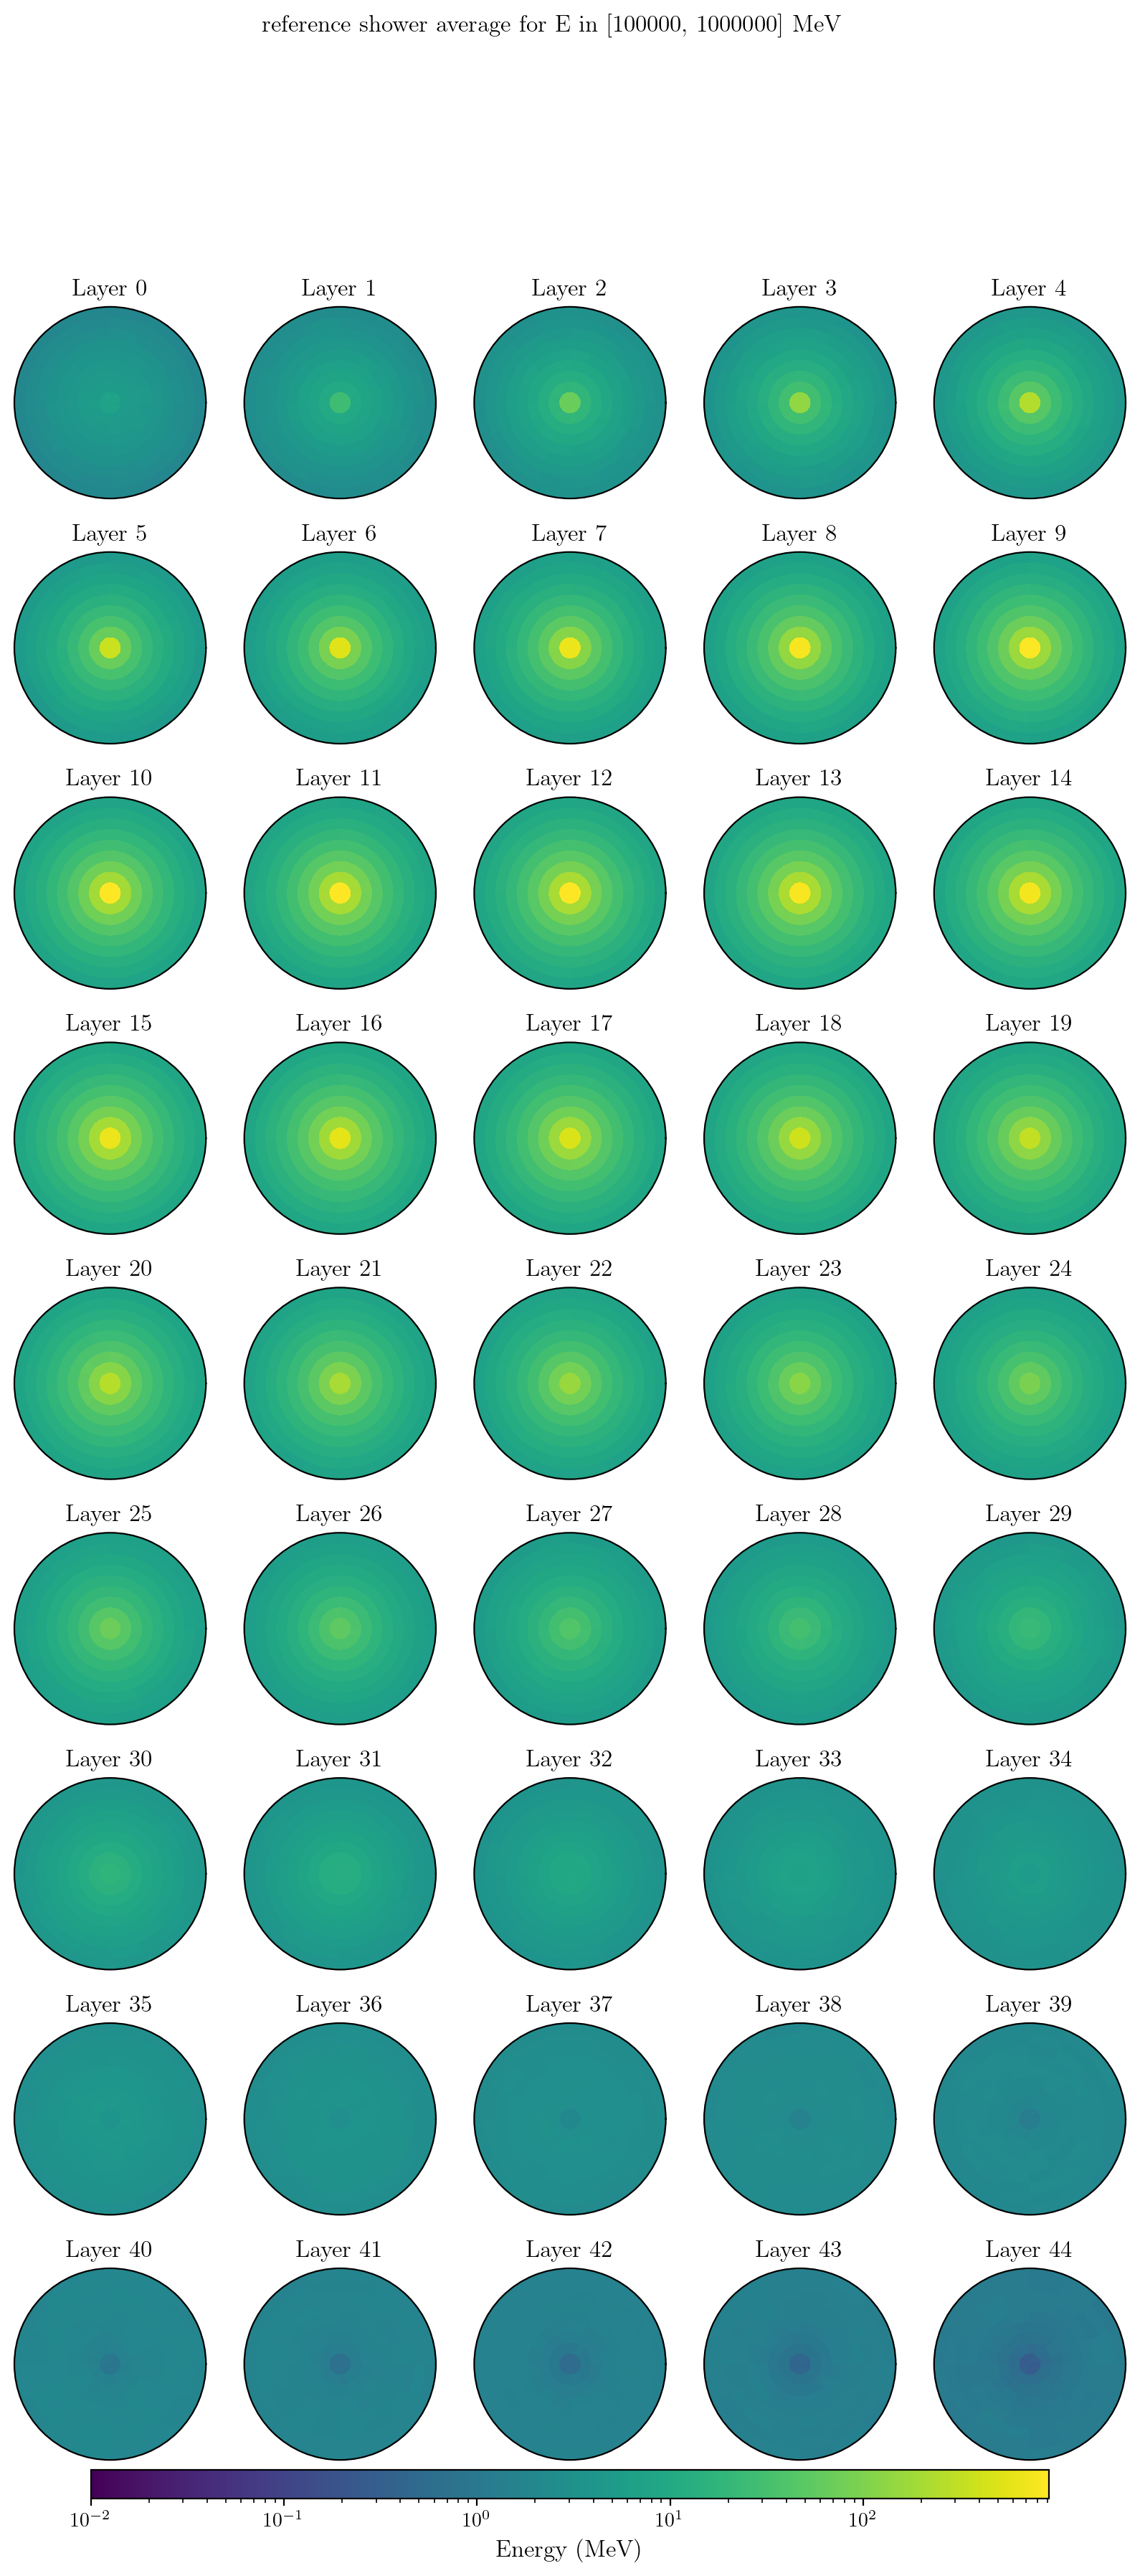

In [8]:
# evaluation mode 'avg-E': average showers at different energy ranges
print("Plotting average showers for different energies ...")
if '1' in args.dataset:
    target_energies = 2**np.linspace(8, 23, 16)
    plot_title = ['shower average at E = {} MeV'.format(int(en)) for en in target_energies]
else:
    target_energies = 10**np.linspace(3, 6, 4)
    plot_title = []
    for i in range(3, 7):
        plot_title.append('shower average for E in [{}, {}] MeV'.format(10**i, 10**(i+1)))
for i in range(len(target_energies)-1):
    filename = 'average_shower_dataset_{}_E_{}.png'.format(args.dataset,
                                                                   target_energies[i])
    which_showers = ((energy >= target_energies[i]) & (energy < target_energies[i+1])).squeeze()
    _ = hlf.DrawAverageShower(shower[which_showers],
                              filename=os.path.join(args.output_dir, filename),
                              title=plot_title[i])
    if hasattr(reference_hlf, 'avg_shower_E'):
        pass
    else:
        reference_hlf.avg_shower_E = {}
    if target_energies[i] in reference_hlf.avg_shower_E:
        pass
    else:
        which_showers = ((reference_hlf.Einc >= target_energies[i]) & (reference_hlf.Einc < target_energies[i+1])).squeeze()
        reference_hlf.avg_shower_E[target_energies[i]] = reference_shower[which_showers].mean(axis=0, keepdims=True)
        evaluate.save_reference(reference_hlf, args.reference_file, args)

        _ = hlf.DrawAverageShower(reference_hlf.avg_shower_E[target_energies[i]],
                                  filename=os.path.join(args.output_dir, 'reference_'+filename),
                                  title='reference '+plot_title[i])

print("Plotting average shower for different energies: DONE.\n")

In [9]:
# evaluation mode 'hist': plotting histograms of high-level features and printing/saving the sepration power
# (equivalent to running hist-p for plotting and hist-chi for the separation power)
print("Calculating high-level features for histograms ...")
hlf.CalculateFeatures(shower)
hlf.Einc = energy

print("Calculating high-level features for histograms: DONE.\n")
if reference_hlf.E_tot is None:
    reference_hlf.CalculateFeatures(reference_shower)
    evaluate.save_reference(reference_hlf, args.reference_file, args)
print("Calculating high-level features for histograms: DONE.\n")

with open(os.path.join(args.output_dir, 'histogram_chi2_{}.txt'.format(args.dataset)), 'w') as f:
    f.write('List of chi2 of the plotted histograms, see eq. 15 of 2009.03796 for its definition.\n')
print("Plotting histograms ...")
evaluate.plot_histograms(hlf, reference_hlf, args)
print("Plotting histograms: DONE. \n")


Calculating high-level features for histograms ...
Calculating high-level features for histograms: DONE.

Saving file with high-level features.
Saving file with high-level features DONE.
Calculating high-level features for histograms: DONE.

Plotting histograms ...
Separation power of Etot / Einc histogram: 0.0005894970393222508
Separation power of E layer 0 histogram: 7.443953022097521e-05
Separation power of E layer 1 histogram: 0.00010201841834316259
Separation power of E layer 2 histogram: 8.941838853914224e-05
Separation power of E layer 3 histogram: 6.0126410714910635e-05
Separation power of E layer 4 histogram: 8.78236461354437e-05
Separation power of E layer 5 histogram: 7.831851533013172e-05
Separation power of E layer 6 histogram: 0.00011273364309711817
Separation power of E layer 7 histogram: 7.926109890219347e-05
Separation power of E layer 8 histogram: 0.00013945603516332273
Separation power of E layer 9 histogram: 8.628262536562437e-05
Separation power of E layer 10 histo

Separation power of EC Phi layer 28 histogram: 0.0005164617907629893
Separation power of EC Phi layer 29 histogram: 0.0005470347580006633
Separation power of EC Phi layer 30 histogram: 0.0005120968237999225
Separation power of EC Phi layer 31 histogram: 0.00042607013933174906
Separation power of EC Phi layer 32 histogram: 0.0005034095474710024
Separation power of EC Phi layer 33 histogram: 0.0005655612046289981
Separation power of EC Phi layer 34 histogram: 0.000580752533990583
Separation power of EC Phi layer 35 histogram: 0.0006407277440868604
Separation power of EC Phi layer 36 histogram: 0.0005433551729186483
Separation power of EC Phi layer 37 histogram: 0.0005810113472425945
Separation power of EC Phi layer 38 histogram: 0.0005811706899717539
Separation power of EC Phi layer 39 histogram: 0.0005819811451598851
Separation power of EC Phi layer 40 histogram: 0.0005121027727607201
Separation power of EC Phi layer 41 histogram: 0.0005285166041730031
Separation power of EC Phi layer 4